In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam import interactions
from ionization import ionization
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt

path = '/media/robert/Data_Storage/Data/Ionization/MultizoneBessel/ConstantWidth/'
lam = 0.8
tau = 35.

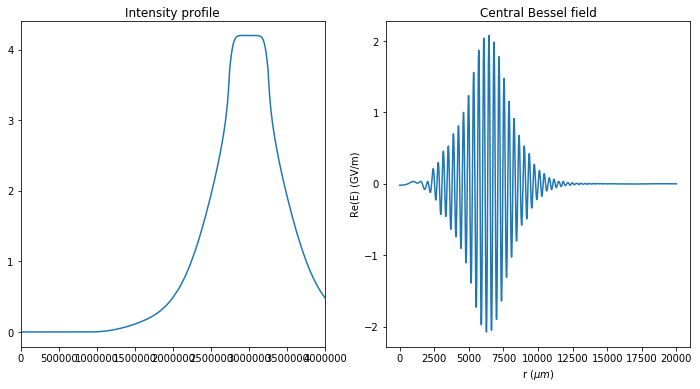

In [2]:
# Create the desired intensity profile
ion = {'atom' : ionization.Ar,
       'tau' : tau,
       'type' : 'gaussian'}
z0 = 2.75e6
zf = 100e6
dz = 0.5e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 100000
z, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, 4, 0.25, zf)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(z, I)
plt.title('Intensity profile')
plt.xlim([0, 4e6])

params = {
    'Nr' : 5000,
    'R' : 20e3,
    'w' : 140,
    'lam' : 0.8
}
rJ0, EJ0 = bessel.bessel_expansion(params, z, I)
plt.subplot(122)
plt.plot(rJ0, EJ0.real)
plt.title('Central Bessel field')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel('Re(E) (GV/m)')
plt.show()

In [3]:
# First we calculate the radius for each higher order mode. 
z00 = 2.75e6
zfinal = 3.25e6
N = 16
theta = np.zeros(N, dtype='double')
radius = np.zeros(N, dtype='double')
radius[0] = 12500
theta[0] = radius[0]/zfinal
for i in range(1, N):
    theta[i] = theta[0]*(zfinal/z00)**i
    radius[i] = zfinal*theta[i]
print(radius/1e4)
print(2.4048*lam/(2*np.pi*theta))

[  1.25         1.47727273   1.74586777   2.06329827   2.43844341
   2.88179676   3.40575981   4.02498886   4.75680502   5.62167866
   6.64380205   7.85176606   9.27935989  10.96651624  12.96042828
  15.31686978]
[ 79.60904789  67.36150206  56.99819405  48.22924112  40.80935787
  34.53099512  29.21853433  24.7233752   20.91977902  17.70135148
  14.97806664  12.67374869  10.7239412    9.07410409   7.67808808
   6.49684376]


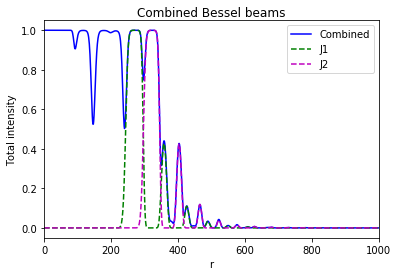

In [4]:
# First we need to figure out the strength of each Bessel
atom = ionization.Ar
ion = {
    'atom' : atom,
    'tau' : tau,
    'type' : 'gaussian'
}
coef = [0.75, 1.3, 1.8, 2.1, 2.8, 3.2]
order = [0, 3, 6, 9, 14, 20]
R = [140, 67, 57, 48, 41, 35]
r = np.linspace(0, 1e3, 1000)
ne, nj = bessel.multimode_transverse_estimate(r, ion, coef, order, R)
plt.plot(r, ne, 'b', r, nj[4, :], 'g--', r, nj[5, :], 'm--')
plt.title('Combined Bessel beams')
plt.xlabel('r')
plt.ylabel('Total intensity')
plt.legend(['Combined', 'J1', 'J2'])
plt.xlim([0, 1000])
plt.show()

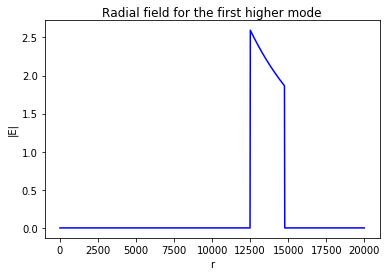

In [5]:
# Second we need to figure out how to create these modes
E0 = 2.6
r = np.linspace(0, 2e4, 1000)
E = np.zeros(1000, dtype='complex128')
sel = (r < radius[1]) * (r > radius[0])
E[sel] = E0*radius[0]**2/r[sel]**2
E *= np.exp(-1j*theta[1]*2*np.pi/lam*r)
plt.plot(r, abs(E), 'b')
plt.title('Radial field for the first higher mode')
plt.xlabel('r')
plt.ylabel('|E|')
plt.show()

In [6]:
# Lets test a Fourier propagation of the beam
beamParams = {
    'Nx' : 2**11,
    'Ny' : 2**11,
    'X' : 4e4,
    'Y' : 4e4,
    'lam' : lam,
    'path' : path,
    'name' : 'Mode1Beam',
    'load' : False,
    'threads' : 4,
    'cyl' : True,
    'order' : order[1],
    'r' : r,
    'E' : E
}
Mode1Beam = laserbeam.RadialLaser(beamParams)

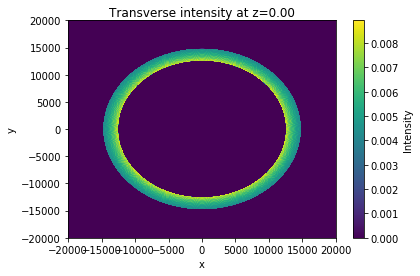

1.14319706116


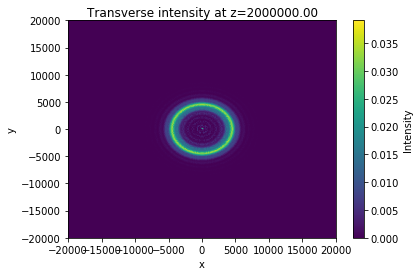

In [7]:
Mode1Beam.plot_current_intensity()
print(Mode1Beam.total_cyl_power(Mode1Beam.x[int(Mode1Beam.Nx/2):], 
                          Mode1Beam.intensity_from_field(Mode1Beam.e[int(Mode1Beam.Nx/2):,
                                                                     int(Mode1Beam.Ny/2)])))
Mode1Beam.propagate(2e6, 1.0)
Mode1Beam.plot_current_intensity()

In [8]:
Mode1Beam.propagate(np.linspace(0, 2e6, 500), 1.0)

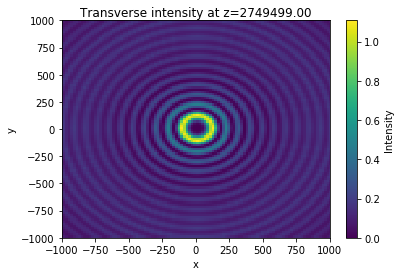

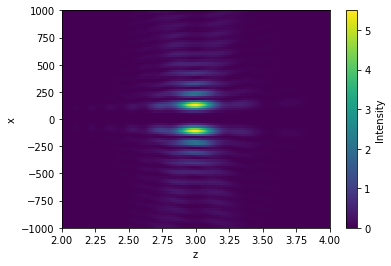

In [9]:
Mode1Beam.plot_intensity_at(189, lim=[-1000, 1000])
Eout = np.zeros((500, Mode1Beam.Nx), dtype='complex128')
for i in range(500):
    Eout[i] = Mode1Beam.load_field(i+2)[0]
Iout = Mode1Beam.intensity_from_field(Eout)

Iout = Mode1Beam.prep_data(Iout)
X = Mode1Beam.X
im = plt.imshow(Iout, aspect='auto', extent=[2, 4, -X/2, X/2])
cb = plt.colorbar()
cb.set_label(r'Intensity')
plt.set_cmap('viridis')
plt.xlabel(r'z')
plt.ylabel(r'x')
plt.ylim([-1000, 1000])
plt.show()

53.0377438315


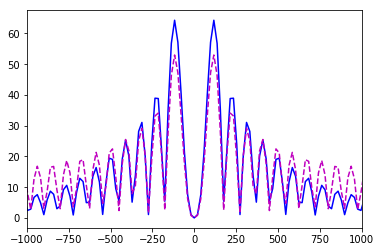

In [10]:
from scipy.special import jn
etran = Mode1Beam.load_field(251)[0]
x = Mode1Beam.x
E0 = ionization.field_from_intensity(ionization.intensity_from_density(ion, 0.999))
print(E0)
k = 2.4048/np.array(R, dtype='double')
j1 = abs(E0*(1+coef[1])*jn(order[1], k[1]*x))
plt.plot(x, abs(etran), 'b', x, j1, 'm--')
plt.xlim([-1000, 1000])
plt.show()

In [11]:
M = len(coef)
E0i = np.zeros(M, dtype='double')
r = np.linspace(0, 3e4, 1000)
beams = {}
    
beamParams = {
    'Nx' : 2**12,
    'Ny' : 2**12,
    'X' : 6e4,
    'Y' : 6e4,
    'lam' : lam,
    'path' : path,
    'load' : False,
    'threads' : 4,
    'cyl' : True,
    'r' : r,
}

for i in range(1, M):
    E = np.zeros(1000, dtype='complex128')
    sel = (r < radius[i]) * (r > radius[i-1])
    E[sel] = radius[i]**2/r[sel]**2
    E *= np.exp(-1j*theta[i]*2*np.pi/lam*r)
    beamParams['name'] = 'Beam' + str(i)
    beamParams['order'] = order[i]
    beamParams['E'] = E
    beam = beams['Beam'+str(i)] = laserbeam.RadialLaser(beamParams)
    beam.propagate(3e6, 1.0)
    Ebeam = np.amax(abs(beam.load_field(1)[0]))
    Ebess = np.amax(abs(E0*(1+coef[i])*jn(order[i], k[i]*r)))
    E0i[i] = Ebess/Ebeam

print(E0i)

[ 0.          1.61924814  1.67960894  1.84028664  2.75225124  2.81844754]


0.772222542149


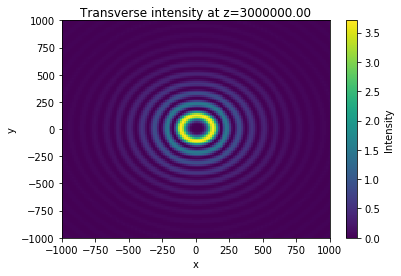

1.09179660003


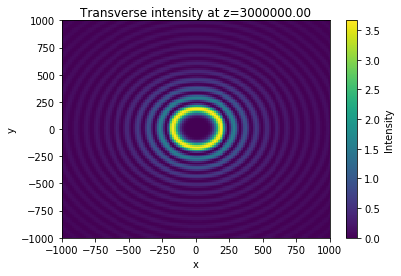

1.63744987284


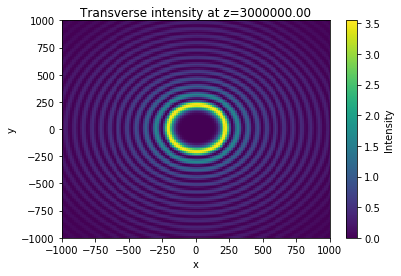

4.4288465262


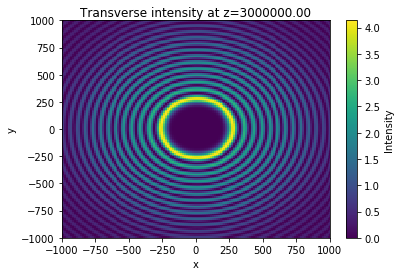

5.21442154148


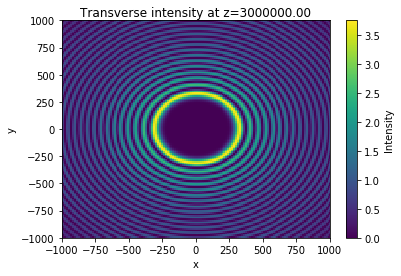

In [12]:
for i in range(1, M):
    E = np.zeros(1000, dtype='complex128')
    sel = (r < radius[i]) * (r > radius[i-1])
    E[sel] = E0i[i]*radius[i]**2/r[sel]**2
    E *= np.exp(-1j*theta[i]*2*np.pi/lam*r)
    beamParams['name'] = 'Beam' + str(i)
    beamParams['order'] = order[i]
    beamParams['E'] = E
    beam = beams['Beam'+str(i)] = laserbeam.RadialLaser(beamParams)
    beam.propagate(3e6, 1.0)
    print(beam.total_cyl_power(beam.x[int(beam.Nx/2):], 
                          beam.intensity_from_field(beam.e[int(beam.Nx/2):, int(beam.Ny/2)])))
    beam.plot_current_intensity(lim=[-1000, 1000])

In [13]:
del beam
del beams
del Mode1Beam

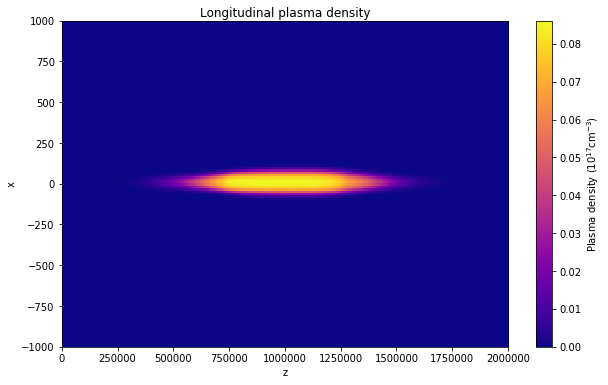

In [14]:
pulseParams = {
    'Nx' : 2**12,
    'Ny' : 2**11,
    'Nt' : 2**6,
    'X' : 6e4,
    'Y' : 6e4,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : False,
    'threads' : 4,
    'cyl' : True,
    'tau' : tau,
}

plasmaParams = {
    'Nx' : pulseParams['Nx'],
    'Ny' : pulseParams['Ny'],
    'Nz' : 2**8,
    'X' : pulseParams['X'],
    'Y' : pulseParams['Y'],
    'Z' : 2.0e6,
    'n0' : 0.1,
    'atom' : ionization.Ar,
    'path' : path,
    'load' : False,
    'cyl' : True
}

# Central Bessel function
pulseParams['name'] = 'J0Beam'
pulseParams['order'] = 0
pulseParams['r'] = rJ0
pulseParams['E'] = EJ0
beam = laserbeam.RadialLaser(pulseParams)
beam.propagate(2.0e6, 1.0)
pulseParams['name'] = 'J0Pulse'
pulseParams['r'] = beam.x
pulseParams['E'] = beam.e[:, int(beam.Ny/2)]
pulse = laserpulse.RadialPulse(pulseParams)
plasmaParams['name'] = 'Plasma0'
argon = plasma.UniformPlasma(plasmaParams)
interactions.pulse_plasma(pulse, argon)
argon.plot_long_density_center(lim=[-1000, 1000])

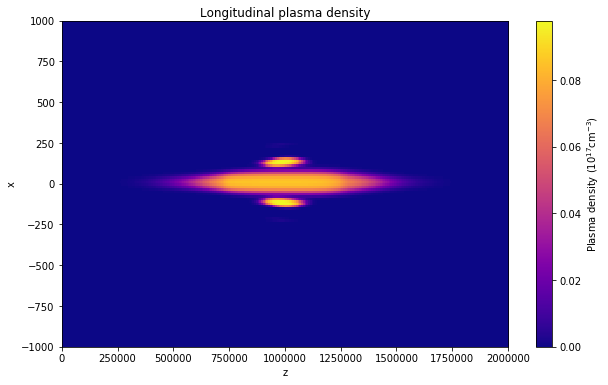

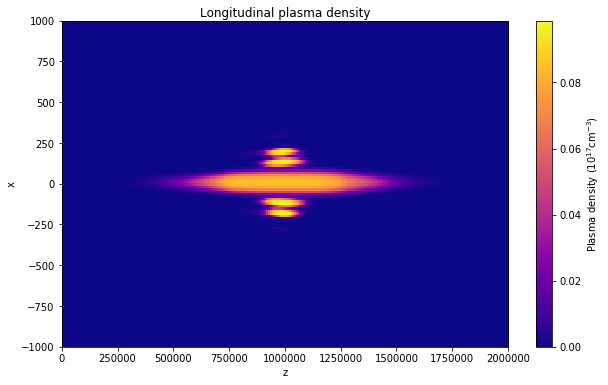

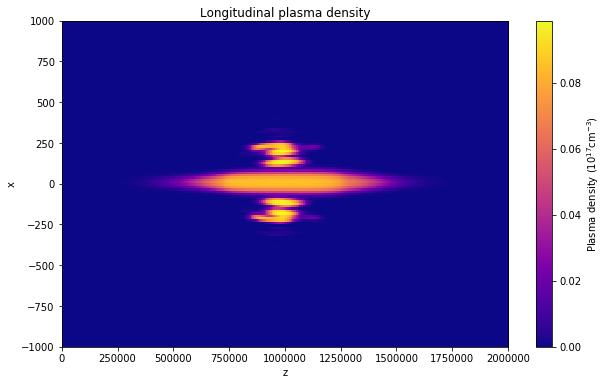

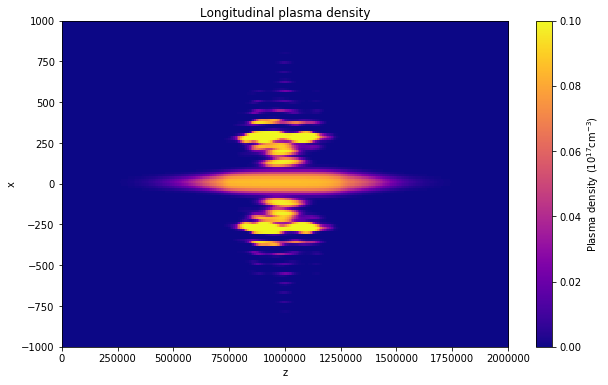

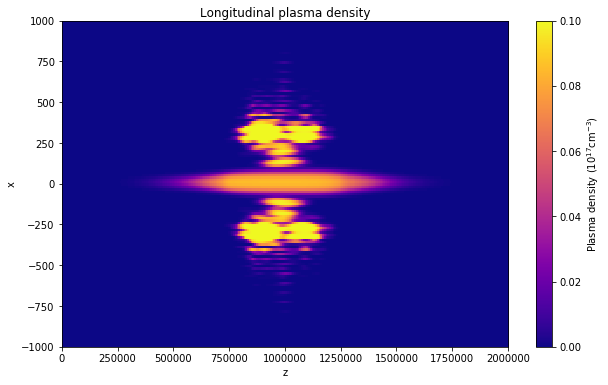

In [15]:
# Higher order Bessel zones
for i in range(1, M):
    E = np.zeros(1000, dtype='complex128')
    sel = (r < radius[i]) * (r > radius[i-1])
    E[sel] = E0i[i]*radius[i]**2/r[sel]**2
    E *= np.exp(-1j*theta[i]*2*np.pi/lam*r)
    pulseParams['name'] = 'J'+str(order[i])+'Beam'
    pulseParams['order'] = order[i]
    pulseParams['r'] = r
    pulseParams['E'] = E
    beam = laserbeam.RadialLaser(pulseParams)
    beam.propagate(2.0e6, 1.0)
    pulseParams['name'] = 'J'+str(order[i])+'Pulse'
    pulseParams['r'] = beam.x
    pulseParams['E'] = beam.e[:, int(beam.Ny/2)]
    pulse = laserpulse.RadialPulse(pulseParams)
    plasmaParams['sourcePath'] = path
    plasmaParams['sourceName'] = plasmaParams['name']
    plasmaParams['name'] = 'Plasma' + str(i)
    argon = plasma.ExistingPlasma(plasmaParams)
    interactions.pulse_plasma(pulse, argon)
    argon.plot_long_density_center(lim=[-1000, 1000])